In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("I am using my NVIDIA RTX 3080 for training so I don't hit training limits")



from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
import json
import pandas as pd

import snowflake.ml.modeling.preprocessing as snowml_preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# get account credentials from a json file
with open("connection.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]
    role = data["role"]
    database = data["database"]
    schema = data["schema"]
    
# specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": role,
    "database": database,
    "schema": schema
}

session = Session.builder.configs(connection_parameters).create()

Num GPUs Available:  1
I am using my NVIDIA RTX 3080 for training so I don't hit training limits


In [2]:
def plot_learning(history, tgt='loss', val_tgt='val_loss', ylab='error', title='default'):
    plt.plot(history.history[tgt], label=tgt)
    plt.plot(history.history[val_tgt], label=val_tgt)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylab)
    plt.legend()

### Loading the data from Snowflake
As you can see from the marchmadness_ML.ipynb file, I am using a combination of Ibis and Snowpark for the feature engineering because I have free compute there and it will accelerate the process with distributed compute

### Randomizing the data   
Since in our training data we have W conference always in class '1' we need to go ahead and randomize all the data from W and L so that we have winning observations on both sides of the features

In [3]:
test_df = session.table('JOE_TEST').to_pandas()
test_df = test_df[test_df['WIN_INDICATOR'] == 1]
cols = test_df.columns

for index, row in test_df.iterrows():
    if np.random.rand() > 0.5:
        for col in cols:
            if col.startswith("W_"):
                test_df.at[index, col] = row["L_"+col[2:]]
            elif col.startswith("L_"):
                test_df.at[index, col] = row["W_"+col[2:]]
test_df['WIN_INDICATOR'] = np.where(test_df["W_SCORE"] > test_df['L_SCORE'], 1, 0)
test_df

,W_CONF_ACC,W_CONF_AEC,W_CONF_A_SUN,W_CONF_A_TEN,W_CONF_BIG_EAST,W_CONF_BIG_SKY,W_CONF_BIG_SOUTH,W_CONF_BIG_TEN,W_CONF_BIG_TWELVE,W_CONF_BIG_WEST,...,L_PF_STDDEV,L_W1COLUMN_STDDEV,L_W2COLUMN_STDDEV,L_WINMARGINMEDIAN,L_WINMARGINMEAN,L_LOSEMARGINMEDIAN,L_LOSEMARGINMEAN,L_REGION,WIN_INDICATOR,ROUND
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.369694,10.506526,9.763122,14.0,16.880000,5.0,7.428571,W,0,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.661852,9.921466,7.983855,9.0,11.315789,6.0,7.769231,X,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.552509,9.335545,9.490778,18.0,19.838710,16.0,12.000000,Z,1,3
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.373807,9.629893,9.453234,12.0,13.960000,6.5,9.000000,X,1,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.472566,8.899694,8.496434,7.0,8.956522,4.0,8.100000,Y,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.644345,7.941761,9.320243,14.0,16.200000,4.0,7.714286,Z,0,1
130,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.017453,11.469288,10.896736,11.5,12.607143,4.5,5.833333,W,0,1
131,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.660307,8.945835,8.535316,14.0,13.958333,5.0,8.000000,X,0,1
132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4.486301,7.013920,7.361731,18.0,16.421053,7.5,9.857143,X,1,1


### Do the same for the test data

In [4]:
train_df = session.table('JOE_TRAIN').to_pandas()
train_df = train_df[train_df['WIN_INDICATOR'] == 1]
cols = train_df.columns

for index, row in train_df.iterrows():
    if np.random.rand() > 0.5:
        for col in cols:
            if col.startswith("W_"):
                train_df.at[index, col] = row["L_"+col[2:]]
            elif col.startswith("L_"):
                train_df.at[index, col] = row["W_"+col[2:]]
                
train_df['WIN_INDICATOR'] = np.where(train_df["W_SCORE"] > train_df['L_SCORE'], 1, 0)

train_df

,W_CONF_ACC,W_CONF_AEC,W_CONF_A_SUN,W_CONF_A_TEN,W_CONF_BIG_EAST,W_CONF_BIG_SKY,W_CONF_BIG_SOUTH,W_CONF_BIG_TEN,W_CONF_BIG_TWELVE,W_CONF_BIG_WEST,...,L_PF_STDDEV,L_W1COLUMN_STDDEV,L_W2COLUMN_STDDEV,L_WINMARGINMEDIAN,L_WINMARGINMEAN,L_LOSEMARGINMEDIAN,L_LOSEMARGINMEAN,L_REGION,ROUND,WIN_INDICATOR
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.676209,8.084670,8.898849,13.0,12.550000,10.0,11.500000,Y,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.989178,10.378231,8.530369,14.0,17.280000,5.0,4.333333,Z,4,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.001293,10.864949,11.193389,18.0,22.000000,7.0,8.142857,Z,2,0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.925894,12.251390,10.136086,15.0,16.157895,17.0,15.545455,W,3,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.941886,9.447712,11.450003,7.0,7.850000,10.0,14.714286,W,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.032542,7.641420,9.853071,7.5,13.214286,11.0,10.000000,Z,1,0
1164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.695272,10.752829,10.754844,9.5,14.437500,10.0,11.444444,Y,2,0
1165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.239690,10.544168,7.590668,14.0,15.739130,13.5,15.000000,X,1,0
1166,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,7.229168,11.274490,10.456864,12.0,13.391304,2.0,2.000000,Z,1,1


In [142]:
test_df_all = session.table('JOE_TEST').to_pandas()
train_df_all = session.table('JOE_TRAIN').to_pandas()

### split out the x and y for both sets

In [5]:
x_train = train_df.drop(['SEASON', 'WIN_INDICATOR','L_TEAMID','W_TEAMID','W_SCORE','L_SCORE','ROUND','L_REGION','W_REGION', 'ROUND'], axis=1)
x_test = test_df.drop(['SEASON', 'WIN_INDICATOR','L_TEAMID','W_TEAMID','W_SCORE','L_SCORE','ROUND','L_REGION','W_REGION', 'ROUND'], axis=1)
y_train = train_df['WIN_INDICATOR']
y_test = test_df['WIN_INDICATOR']

x_train_all = train_df_all.drop(['SEASON', 'WIN_INDICATOR','L_TEAMID','W_TEAMID','W_SCORE','L_SCORE','ROUND','L_REGION','W_REGION', 'ROUND'], axis=1)
x_test_all = test_df_all.drop(['SEASON', 'WIN_INDICATOR','L_TEAMID','W_TEAMID','W_SCORE','L_SCORE','ROUND','L_REGION','W_REGION', 'ROUND'], axis=1)
y_train_all = train_df_all['WIN_INDICATOR']
y_test_all = test_df_all['WIN_INDICATOR']

NameError: name 'train_df_all' is not defined

In [ ]:
print(x_train.shape)
x_train.columns.to_list()

(1168, 172)


['W_CONF_ACC',
 'W_CONF_AEC',
 'W_CONF_A_SUN',
 'W_CONF_A_TEN',
 'W_CONF_BIG_EAST',
 'W_CONF_BIG_SKY',
 'W_CONF_BIG_SOUTH',
 'W_CONF_BIG_TEN',
 'W_CONF_BIG_TWELVE',
 'W_CONF_BIG_WEST',
 'W_CONF_CAA',
 'W_CONF_CUSA',
 'W_CONF_HORIZON',
 'W_CONF_IVY',
 'W_CONF_MAAC',
 'W_CONF_MAC',
 'W_CONF_MEAC',
 'W_CONF_MID_CONT',
 'W_CONF_MVC',
 'W_CONF_MWC',
 'W_CONF_NEC',
 'W_CONF_OVC',
 'W_CONF_PAC_TEN',
 'W_CONF_PAC_TWELVE',
 'W_CONF_PATRIOT',
 'W_CONF_SEC',
 'W_CONF_SOUTHERN',
 'W_CONF_SOUTHLAND',
 'W_CONF_SUMMIT',
 'W_CONF_SUN_BELT',
 'W_CONF_SWAC',
 'W_CONF_WAC',
 'W_CONF_WCC',
 'L_CONF_ACC',
 'L_CONF_AEC',
 'L_CONF_A_SUN',
 'L_CONF_A_TEN',
 'L_CONF_BIG_EAST',
 'L_CONF_BIG_SKY',
 'L_CONF_BIG_SOUTH',
 'L_CONF_BIG_TEN',
 'L_CONF_BIG_TWELVE',
 'L_CONF_BIG_WEST',
 'L_CONF_CAA',
 'L_CONF_CUSA',
 'L_CONF_HORIZON',
 'L_CONF_IVY',
 'L_CONF_MAAC',
 'L_CONF_MAC',
 'L_CONF_MEAC',
 'L_CONF_MID_CONT',
 'L_CONF_MVC',
 'L_CONF_MWC',
 'L_CONF_NEC',
 'L_CONF_OVC',
 'L_CONF_PAC_TEN',
 'L_CONF_PAC_TWELVE',
 'L_C

### Send to numpy for the NN

In [6]:
import numpy as np

np_x_train = x_train.to_numpy()
np_x_test = x_test.to_numpy()
np_y_train = y_train.to_numpy()
np_y_test = y_test.to_numpy()

np_x_train_all = x_train.to_numpy()
np_x_test_all = x_test.to_numpy()
np_y_train_all = y_train.to_numpy()
np_y_test_all = y_test.to_numpy()

### First classify NN
I have looked into MANY of the different NNs that people have used for sports betting and classification in general. They all follow this general structure, but I am going to play around with the deep layers and see what we can determine

In [7]:
class MLPClassify_1(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]))
        self.net.add(Dense(500, activation='relu'))
        self.net.add(Dense(150, activation='relu'))
        # self.net.add(Dense(10, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

### Optimizer testing
When I was doing the writing assignments I noticed a very big impact in the different optimizers so we will begin by testing those on our data sets. My hypothesis is that adam will outperform SGD, but let's test that

In [8]:
from tensorflow.keras.optimizers import Adam
model_1_sgd =  MLPClassify_1()
# sgd = optimizers.SGD(learning_rate=0.1)
model_1_sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.01), loss='binary_crossentropy',
    metrics='accuracy')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 172)               29756     
                                                                 
 dense_1 (Dense)             (None, 500)               86500     
                                                                 
 dense_2 (Dense)             (None, 150)               75150     
                                                                 
 dense_3 (Dense)             (None, 1)                 151       
                                                                 
Total params: 191,557
Trainable params: 191,557
Non-trainable params: 0
_________________________________________________________________


In [199]:
model_2_adam = MLPClassify_1()
model_2_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 dense_212 (Dense)           (None, 172)               29756     
                                                                 
 dense_213 (Dense)           (None, 500)               86500     
                                                                 
 dense_214 (Dense)           (None, 150)               75150     
                                                                 
 dense_215 (Dense)           (None, 1)                 151       
                                                                 
Total params: 191,557
Trainable params: 191,557
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model_1_sgd.fit(
    np_x_train,
    np_y_train,
    epochs=200,
    validation_data=(np_x_test,np_y_test))

Epoch 1/200
37/37 [==============================] - 2s 11ms/step - loss: 2.9665 - accuracy: 0.4949 - val_loss: 0.6898 - val_accuracy: 0.5373
Epoch 2/200
37/37 [==============================] - 0s 6ms/step - loss: 0.6887 - accuracy: 0.5488 - val_loss: 0.6796 - val_accuracy: 0.5896
Epoch 3/200
37/37 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.5240 - val_loss: 0.6910 - val_accuracy: 0.5149
Epoch 4/200
37/37 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.5428 - val_loss: 0.6798 - val_accuracy: 0.6493
Epoch 5/200
37/37 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.5402 - val_loss: 0.6783 - val_accuracy: 0.5000
Epoch 6/200
37/37 [==============================] - 0s 7ms/step - loss: 0.6883 - accuracy: 0.5522 - val_loss: 0.7052 - val_accuracy: 0.4851
Epoch 7/200
37/37 [==============================] - 0s 7ms/step - loss: 0.6891 - accuracy: 0.5479 - val_loss: 0.6780 - val_accuracy: 0.5299
Epoch 8/200


In [200]:
history2 = model_2_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=300,
    validation_data=(np_x_test_all,np_y_test_all))

Epoch 1/300
37/37 [==============================] - 1s 14ms/step - loss: 1.4789 - Accuracy: 0.5514 - val_loss: 0.7190 - val_Accuracy: 0.5299
Epoch 2/300
37/37 [==============================] - 0s 8ms/step - loss: 0.6933 - Accuracy: 0.6045 - val_loss: 0.6282 - val_Accuracy: 0.6493
Epoch 3/300
37/37 [==============================] - 0s 7ms/step - loss: 0.6255 - Accuracy: 0.6524 - val_loss: 0.6710 - val_Accuracy: 0.6567
Epoch 4/300
37/37 [==============================] - 0s 7ms/step - loss: 0.6962 - Accuracy: 0.6096 - val_loss: 0.6375 - val_Accuracy: 0.6343
Epoch 5/300
37/37 [==============================] - 0s 7ms/step - loss: 0.5969 - Accuracy: 0.6772 - val_loss: 0.6172 - val_Accuracy: 0.6791
Epoch 6/300
37/37 [==============================] - 0s 7ms/step - loss: 0.5763 - Accuracy: 0.6909 - val_loss: 0.6268 - val_Accuracy: 0.6866
Epoch 7/300
37/37 [==============================] - 0s 7ms/step - loss: 0.5656 - Accuracy: 0.6978 - val_loss: 0.6503 - val_Accuracy: 0.6119
Epoch 8/300


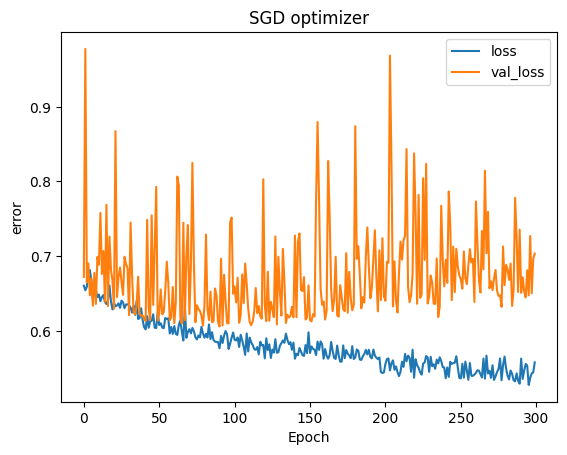

In [ ]:
plot_learning(history, title='SGD optimizer')

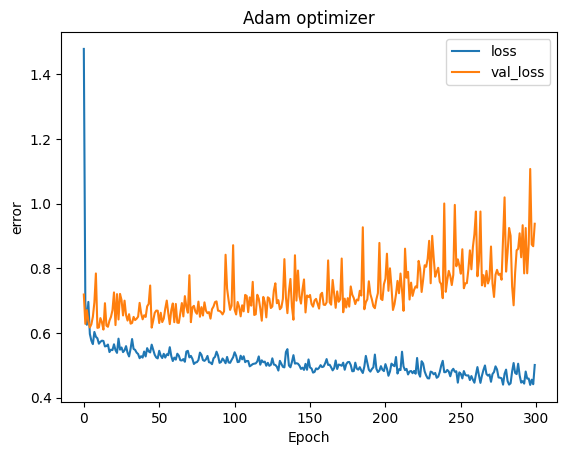

In [ ]:
plot_learning(history2, title='Adam optimizer')

In [ ]:
model_1_sgd.evaluate(np_x_test, np_y_test)

5/5 [==============================] - 0s 5ms/step - loss: 0.7035 - accuracy: 0.5149


[0.703521728515625, 0.5149253606796265]

In [ ]:
model_2_adam.evaluate(np_x_test, np_y_test)

5/5 [==============================] - 0s 5ms/step - loss: 0.9380 - Accuracy: 0.6343


[0.9379969239234924, 0.6343283653259277]

### Optimizer Results
My hypthosis was correct, and the Adam optimizer outperformed the SGD optimizer when forward testing. We will move forward with that. However we can see that we are underfitting.

### Regularizers
Let's test the impact of a regularizer on the data

In [14]:
from keras import regularizers
class MLPClassify_2(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]),)
        self.net.add(Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dense(500, activation='relu'))
        # self.net.add(Dense(172, activation='relu'))
        self.net.add(Dense(10, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

In [15]:
model_3_adam = MLPClassify_2()
model_3_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 172)               29756     
                                                                 
 dense_9 (Dense)             (None, 500)               86500     
                                                                 
 dense_10 (Dense)            (None, 10)                5010      
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 121,277
Trainable params: 121,277
Non-trainable params: 0
_________________________________________________________________


In [16]:
history3 = model_3_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all))

Epoch 1/200
37/37 [==============================] - 1s 16ms/step - loss: 2.4301 - Accuracy: 0.4777 - val_loss: 1.7479 - val_Accuracy: 0.4851
Epoch 2/200
37/37 [==============================] - 0s 10ms/step - loss: 1.4482 - Accuracy: 0.4829 - val_loss: 1.2280 - val_Accuracy: 0.5149
Epoch 3/200
37/37 [==============================] - 0s 7ms/step - loss: 1.1322 - Accuracy: 0.5171 - val_loss: 1.0570 - val_Accuracy: 0.5149
Epoch 4/200
37/37 [==============================] - 0s 7ms/step - loss: 1.0156 - Accuracy: 0.5171 - val_loss: 0.9780 - val_Accuracy: 0.5149
Epoch 5/200
37/37 [==============================] - 0s 7ms/step - loss: 0.9513 - Accuracy: 0.5171 - val_loss: 0.9251 - val_Accuracy: 0.5149
Epoch 6/200
37/37 [==============================] - 0s 6ms/step - loss: 0.9054 - Accuracy: 0.5171 - val_loss: 0.8849 - val_Accuracy: 0.5149
Epoch 7/200
37/37 [==============================] - 0s 7ms/step - loss: 0.8681 - Accuracy: 0.5171 - val_loss: 0.8514 - val_Accuracy: 0.5149
Epoch 8/200

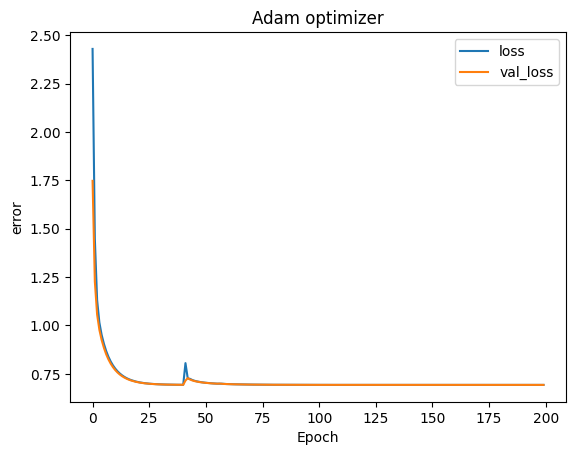

In [17]:
plot_learning(history3, title='Adam optimizer')

In [19]:
model_3_adam.evaluate(np_x_test_all, np_y_test_all)

5/5 [==============================] - 0s 17ms/step - loss: 0.6927 - Accuracy: 0.5149


[0.6927077770233154, 0.5149253606796265]

### Results
So with the regularizer we found that we were slightly more accurate.

### Model with dropouts
Let's test the impact of adding dropouts

In [20]:
from keras import regularizers
from keras.layers import Dropout
class MLPClassify_3(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='sigmoid', input_shape = x_train.shape[1:],kernel_regularizer=regularizers.l2(0.01)))
        self.net.add(Dense(1000,activation='sigmoid', input_shape = x_train.shape[1:],kernel_regularizer=regularizers.l2(0.01)))
        self.net.add(Dropout(0.1))
        self.net.add(Dense(500, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))
        self.net.add(Dropout(0.1))
        # self.net.add(Dense(500, activation='relu'))
        # self.net.add(Dense(172, activation='relu'))
        self.net.add(Dense(10, activation='sigmoid'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

In [21]:
model_4_adam = MLPClassify_3()
model_4_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 172)               29756     
                                                                 
 dense_13 (Dense)            (None, 1000)              173000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_14 (Dense)            (None, 500)               500500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_15 (Dense)            (None, 10)                5010      
                                                                 
 dense_16 (Dense)            (None, 1)                

In [23]:
history3 = model_3_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all))

Epoch 1/200
37/37 [==============================] - 0s 13ms/step - loss: 0.6926 - Accuracy: 0.5171 - val_loss: 0.6927 - val_Accuracy: 0.5149
Epoch 2/200
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - Accuracy: 0.5171 - val_loss: 0.6927 - val_Accuracy: 0.5149
Epoch 3/200
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - Accuracy: 0.5171 - val_loss: 0.6927 - val_Accuracy: 0.5149
Epoch 4/200
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - Accuracy: 0.5171 - val_loss: 0.6927 - val_Accuracy: 0.5149
Epoch 5/200
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - Accuracy: 0.5171 - val_loss: 0.6927 - val_Accuracy: 0.5149
Epoch 6/200
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - Accuracy: 0.5171 - val_loss: 0.6927 - val_Accuracy: 0.5149
Epoch 7/200
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - Accuracy: 0.5171 - val_loss: 0.6927 - val_Accuracy: 0.5149
Epoch 8/200


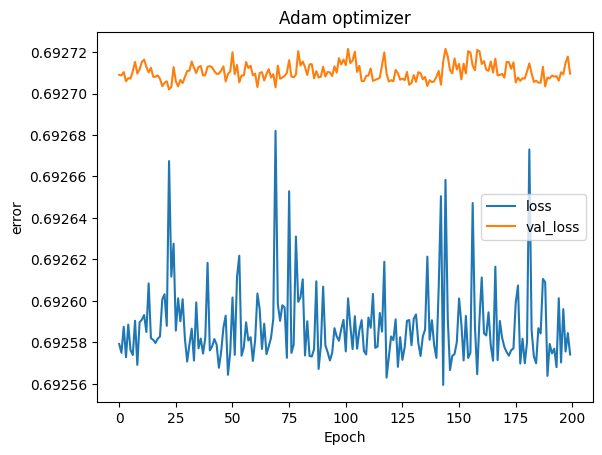

In [24]:
plot_learning(history3, title='Adam optimizer')

In [26]:
model_3_adam.evaluate(np_x_test_all, np_y_test_all)

5/5 [==============================] - 0s 32ms/step - loss: 0.6927 - Accuracy: 0.5149


[0.6927095651626587, 0.5149253606796265]

### Results
With dropouts we see that we are underfitting even further. However I want to go back and test this with the same architecture of dense layers. 

## Additional Feature Engineering and New data balancing approach

In order to address the underfitting I went back and took a look at the features in my data.

When working on the machine learning approach for the kaggle competition at this point I noticed that instead of randomizing the data, we can just flip the data and have each game appear twice, once as a team in the winning column and once as a losing team. This should balance the data better than the randomization approach, and avoid inconsistencies in the sample of the data each time the randomization is run. Not having repeatable accuracies was driving me crazy.

In [28]:
snow_df = session.table('MARCHMADNESS.MEN.FINAL_MODEL_TRAIN')
snow_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
new_cols = {}

for c in snow_df.columns:
    if c.startswith("W"):
        new_cols[c] = "L" + c[1:]
    elif c.startswith("L"):
        new_cols[c] = "W" + c[1:]
    else:
        new_cols[c] = c

df_flipped = snow_df.select([F.col(c).alias(new_cols.get(c, c)) for c in snow_df.columns]).select(
    *[col for col in snow_df.columns]
)

In [30]:
snow_df.limit(1).union_all(df_flipped.limit(1)).to_pandas().head()

,W_CONF_ACC,W_CONF_AEC,W_CONF_A_SUN,W_CONF_A_TEN,W_CONF_BIG_EAST,W_CONF_BIG_SKY,W_CONF_BIG_SOUTH,W_CONF_BIG_TEN,W_CONF_BIG_TWELVE,W_CONF_BIG_WEST,...,L_LOSEMARGINMEDIAN,L_LOSEMARGINMEAN,L_WON_CONFERENCE,L_TOTAL_WINS,W_WLOCN,W_WLOCH,W_WLOCA,L_WLOCN,L_WLOCH,L_WLOCA
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,6.0,7.166667,1,24.0,1,17,6,4,15,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,13.0,10.000000,0,24.0,4,15,5,1,17,6


In [31]:
snow_df = snow_df.with_column("WIN_INDICATOR", F.lit(1))
df_flipped = df_flipped.with_column("WIN_INDICATOR", F.lit(0))

snow_df = snow_df.union_all(df_flipped)

In [32]:
snow_df.distinct().count()

2604

In [33]:
snow_df_check = snow_df.dropDuplicates()
print(snow_df_check.count())
snow_df.columns

2604


['W_CONF_ACC',
 'W_CONF_AEC',
 'W_CONF_A_SUN',
 'W_CONF_A_TEN',
 'W_CONF_BIG_EAST',
 'W_CONF_BIG_SKY',
 'W_CONF_BIG_SOUTH',
 'W_CONF_BIG_TEN',
 'W_CONF_BIG_TWELVE',
 'W_CONF_BIG_WEST',
 'W_CONF_CAA',
 'W_CONF_CUSA',
 'W_CONF_HORIZON',
 'W_CONF_IVY',
 'W_CONF_MAAC',
 'W_CONF_MAC',
 'W_CONF_MEAC',
 'W_CONF_MID_CONT',
 'W_CONF_MVC',
 'W_CONF_MWC',
 'W_CONF_NEC',
 'W_CONF_OVC',
 'W_CONF_PAC_TEN',
 'W_CONF_PAC_TWELVE',
 'W_CONF_PATRIOT',
 'W_CONF_SEC',
 'W_CONF_SOUTHERN',
 'W_CONF_SOUTHLAND',
 'W_CONF_SUMMIT',
 'W_CONF_SUN_BELT',
 'W_CONF_SWAC',
 'W_CONF_WAC',
 'W_CONF_WCC',
 'L_CONF_ACC',
 'L_CONF_AEC',
 'L_CONF_A_SUN',
 'L_CONF_A_TEN',
 'L_CONF_BIG_EAST',
 'L_CONF_BIG_SKY',
 'L_CONF_BIG_SOUTH',
 'L_CONF_BIG_TEN',
 'L_CONF_BIG_TWELVE',
 'L_CONF_BIG_WEST',
 'L_CONF_CAA',
 'L_CONF_CUSA',
 'L_CONF_HORIZON',
 'L_CONF_IVY',
 'L_CONF_MAAC',
 'L_CONF_MAC',
 'L_CONF_MEAC',
 'L_CONF_MID_CONT',
 'L_CONF_MVC',
 'L_CONF_MWC',
 'L_CONF_NEC',
 'L_CONF_OVC',
 'L_CONF_PAC_TEN',
 'L_CONF_PAC_TWELVE',
 'L_C

In [12]:
test_snow_df, train_snow_df = snow_df.random_split(weights=[0.9,0.1], seed=117)

train_df = train_snow_df.to_pandas()
test_df = test_snow_df.to_pandas()

x_train = train_df.drop(['SEASON', 'WIN_INDICATOR','L_TEAMID','W_TEAMID','W_SCORE','L_SCORE','ROUND','L_REGION','W_REGION', 'ROUND'], axis=1)
x_test = test_df.drop(['SEASON', 'WIN_INDICATOR','L_TEAMID','W_TEAMID','W_SCORE','L_SCORE','ROUND','L_REGION','W_REGION', 'ROUND'], axis=1)
y_train = train_df['WIN_INDICATOR']
y_test = test_df['WIN_INDICATOR']

In [13]:
np_x_train = x_train.to_numpy()
np_x_test = x_test.to_numpy()
np_y_train = y_train.to_numpy()
np_y_test = y_test.to_numpy()

np_x_train_all = x_train.to_numpy()
np_x_test_all = x_test.to_numpy()
np_y_train_all = y_train.to_numpy()
np_y_test_all = y_test.to_numpy()

In [35]:
from keras import regularizers
class MLPClassify_1_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]),)
        self.net.add(Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dense(500, activation='relu'))
        # self.net.add(Dense(172, activation='relu'))
        self.net.add(Dense(10, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

In [36]:
model_1_new_adam = MLPClassify_1_new()
model_1_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 172)               29756     
                                                                 
 dense_18 (Dense)            (None, 500)               86500     
                                                                 
 dense_19 (Dense)            (None, 10)                5010      


                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 121,277
Trainable params: 121,277
Non-trainable params: 0
_________________________________________________________________


In [37]:
history3 = model_1_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all))

Epoch 1/200
37/37 [==============================] - 1s 14ms/step - loss: 3.5231 - Accuracy: 0.5180 - val_loss: 1.9799 - val_Accuracy: 0.5000
Epoch 2/200
37/37 [==============================] - 0s 7ms/step - loss: 1.7054 - Accuracy: 0.5848 - val_loss: 1.5286 - val_Accuracy: 0.6119
Epoch 3/200
37/37 [==============================] - 0s 7ms/step - loss: 1.4698 - Accuracy: 0.6353 - val_loss: 1.4090 - val_Accuracy: 0.6269
Epoch 4/200
37/37 [==============================] - 0s 7ms/step - loss: 1.3288 - Accuracy: 0.6507 - val_loss: 1.3744 - val_Accuracy: 0.6269
Epoch 5/200
37/37 [==============================] - 0s 8ms/step - loss: 1.3222 - Accuracy: 0.6344 - val_loss: 1.3328 - val_Accuracy: 0.5672
Epoch 6/200
37/37 [==============================] - 0s 7ms/step - loss: 1.2044 - Accuracy: 0.6918 - val_loss: 1.2967 - val_Accuracy: 0.6418
Epoch 7/200
37/37 [==============================] - 0s 7ms/step - loss: 1.2391 - Accuracy: 0.6464 - val_loss: 1.2738 - val_Accuracy: 0.5821
Epoch 8/200


5/5 [==============================] - 0s 5ms/step - loss: 0.7830 - Accuracy: 0.6493


[0.7829893827438354, 0.6492537260055542]

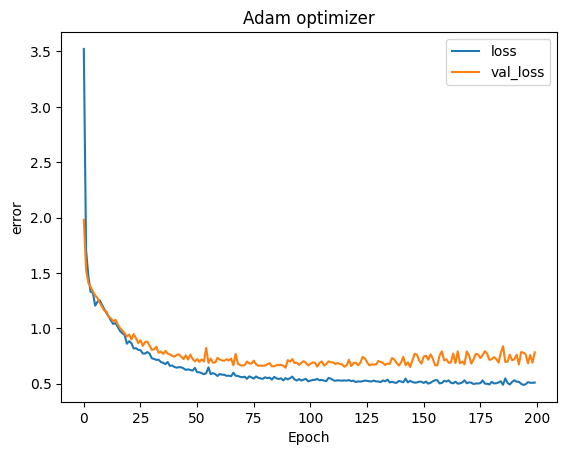

In [38]:
plot_learning(history3, title='Adam optimizer')
model_1_new_adam.evaluate(np_x_test_all, np_y_test_all)

### Changing model structure
Okay that was a good baseline, let's work on the different ways we can structure the deep neural network

In [17]:
class MLPClassify_2_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]),)
        self.net.add(Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        self.net.add(Dense(500, activation='relu'))
        self.net.add(Dense(172, activation='relu'))
        self.net.add(Dense(10, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 172)               29412     
                                                                 
 dense_9 (Dense)             (None, 500)               86500     
                                                                 
 dense_10 (Dense)            (None, 500)               250500    
                                                                 
 dense_11 (Dense)            (None, 172)               86172     
                                                                 
 dense_12 (Dense)            (None, 10)                1730      
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 454,325
Trainable params: 454,325
Non-tr

[2.237025737762451, 0.6441113352775574]

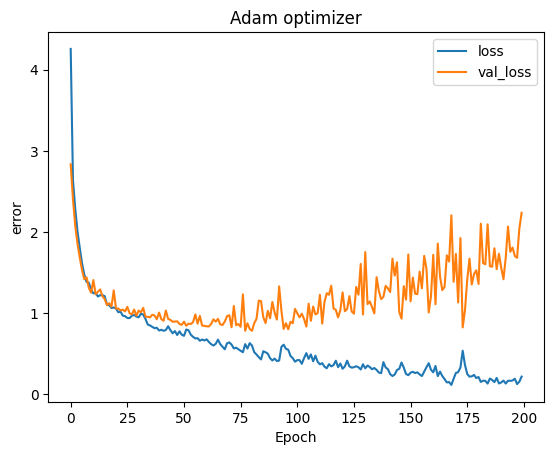

In [18]:
model_2_new_adam = MLPClassify_2_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

In [19]:
class MLPClassify_3_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]),)
        self.net.add(Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dense(500, activation='relu'))
        self.net.add(Dense(172, activation='relu'))
        self.net.add(Dense(10, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 172)               29412     
                                                                 
 dense_15 (Dense)            (None, 500)               86500     
                                                                 
 dense_16 (Dense)            (None, 172)               86172     
                                                                 
 dense_17 (Dense)            (None, 10)                1730      
                                                                 
 dense_18 (Dense)            (None, 1)                 11        
                                                                 
Total params: 203,825
Trainable params: 203,825
Non-trainable params: 0
_________________________________________________________________


73/73 [==============================] - 0s 4ms/step - loss: 0.7070 - Accuracy: 0.4959


[0.7070016860961914, 0.495931476354599]

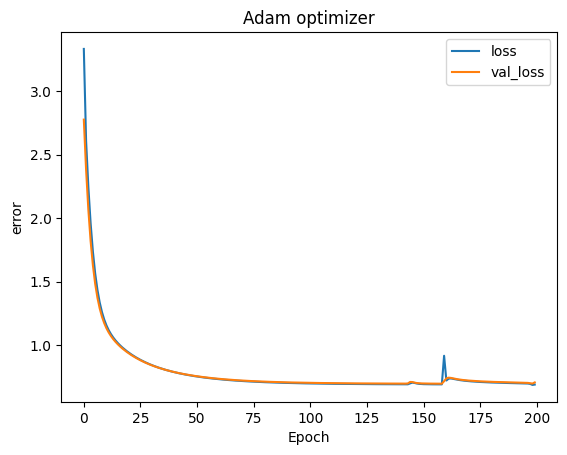

In [20]:
model_2_new_adam = MLPClassify_3_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

In [21]:
# 1000 instead of 500, then 50, then 10

class MLPClassify_4_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]),)
        self.net.add(Dense(1000, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dense(500, activation='relu'))
        self.net.add(Dense(50, activation='relu'))
        self.net.add(Dense(10, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 172)               29412     
                                                                 
 dense_20 (Dense)            (None, 1000)              173000    
                                                                 
 dense_21 (Dense)            (None, 50)                50050     
                                                                 
 dense_22 (Dense)            (None, 10)                510       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 252,983
Trainable params: 252,983
Non-trainable params: 0
_________________________________________________________________
73/73 [==============================] - 0s 4ms/

[1.717391014099121, 0.6569592952728271]

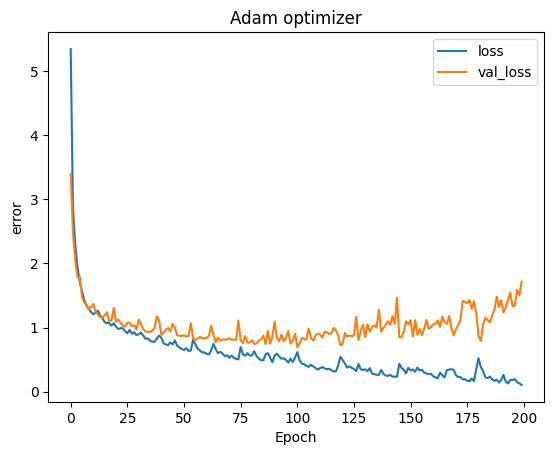

In [22]:
model_2_new_adam = MLPClassify_4_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

In [23]:
class MLPClassify_5_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]),)
        self.net.add(Dense(1000, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dense(500, activation='relu'))
        # self.net.add(Dense(50, activation='relu'))
        self.net.add(Dense(10, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 172)               29412     
                                                                 
 dense_25 (Dense)            (None, 1000)              173000    
                                                                 
 dense_26 (Dense)            (None, 10)                10010     
                                                                 
 dense_27 (Dense)            (None, 1)                 11        
                                                                 
Total params: 212,433
Trainable params: 212,433
Non-trainable params: 0
_________________________________________________________________
73/73 [==============================] - 0s 4ms/step - loss: 0.6983 - Accuracy: 0.4959


[0.698292076587677, 0.495931476354599]

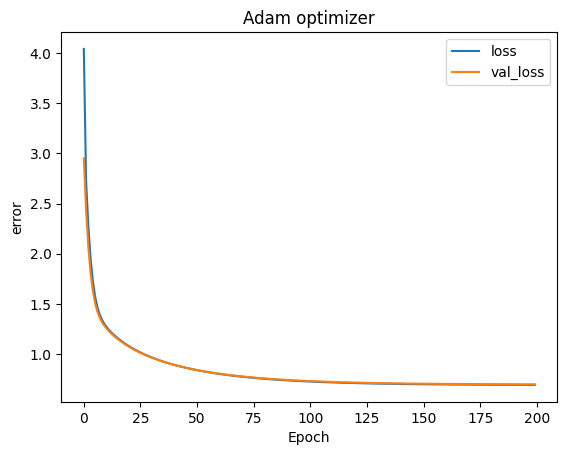

In [24]:
model_2_new_adam = MLPClassify_5_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

In [25]:
#250 to 10

class MLPClassify_6_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]),)
        self.net.add(Dense(250, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dense(500, activation='relu'))
        # self.net.add(Dense(50, activation='relu'))
        self.net.add(Dense(10, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 172)               29412     
                                                                 
 dense_29 (Dense)            (None, 250)               43250     
                                                                 
 dense_30 (Dense)            (None, 10)                2510      
                                                                 
 dense_31 (Dense)            (None, 1)                 11        
                                                                 
Total params: 75,183
Trainable params: 75,183
Non-trainable params: 0
_________________________________________________________________


73/73 [==============================] - 0s 4ms/step - loss: 0.7253 - Accuracy: 0.4959


[0.7253466248512268, 0.495931476354599]

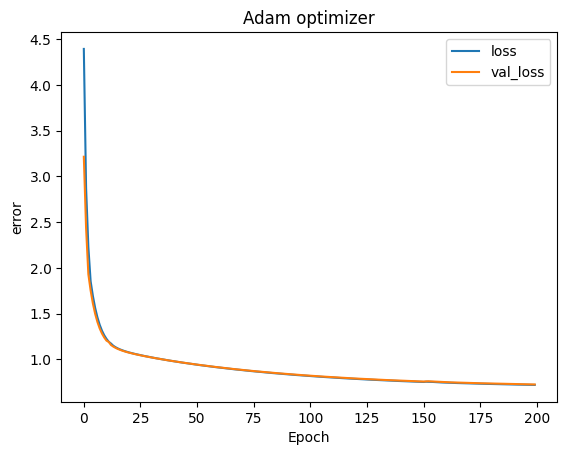

In [26]:
model_2_new_adam = MLPClassify_6_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

In [27]:
class MLPClassify_7_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]),)
        self.net.add(Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        self.net.add(Dense(200, activation='relu'))
        # self.net.add(Dense(50, activation='relu'))
        self.net.add(Dense(10, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 172)               29412     
                                                                 
 dense_33 (Dense)            (None, 500)               86500     
                                                                 
 dense_34 (Dense)            (None, 200)               100200    
                                                                 
 dense_35 (Dense)            (None, 10)                2010      
                                                                 
 dense_36 (Dense)            (None, 1)                 11        
                                                                 
Total params: 218,133
Trainable params: 218,133
Non-trainable params: 0
_________________________________________________________________
73/73 [==============================] - 0s 4ms/

[0.7002342939376831, 0.495931476354599]

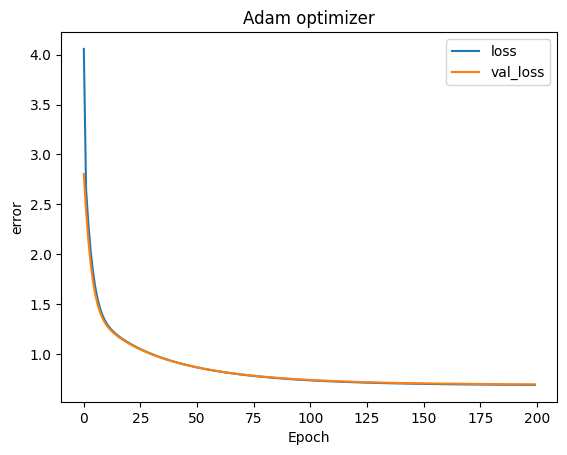

In [28]:
model_2_new_adam = MLPClassify_7_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

In [29]:
class MLPClassify_8_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]),)
        self.net.add(Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dense(200, activation='relu'))
        # self.net.add(Dense(50, activation='relu'))
        self.net.add(Dense(75, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 172)               29412     


                                                                 
 dense_38 (Dense)            (None, 500)               86500     
                                                                 
 dense_39 (Dense)            (None, 75)                37575     
                                                                 
 dense_40 (Dense)            (None, 1)                 76        
                                                                 
Total params: 153,563
Trainable params: 153,563
Non-trainable params: 0
_________________________________________________________________
73/73 [==============================] - 0s 4ms/step - loss: 1.4667 - Accuracy: 0.6552


[1.466728687286377, 0.6552462577819824]

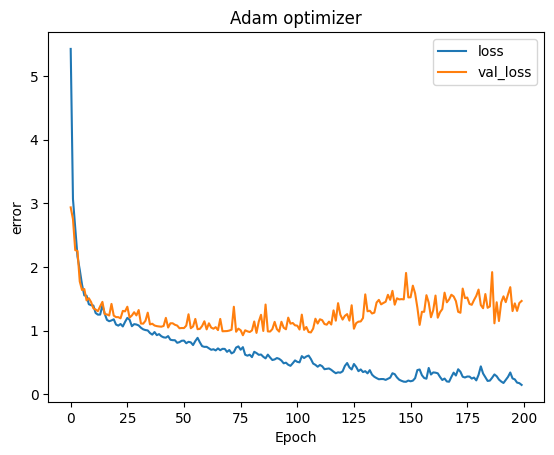

In [30]:
model_2_new_adam = MLPClassify_8_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

### Revert
Let's roll back to the original most accurate model and try without regularizers

In [31]:
# no regularizer

from keras import regularizers
class MLPClassify_9_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]),)
        self.net.add(Dense(500, activation='relu'))#,kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dense(500, activation='relu'))
        # self.net.add(Dense(172, activation='relu'))
        self.net.add(Dense(10, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 172)               29412     
                                                                 
 dense_42 (Dense)            (None, 500)               86500     
                                                                 


 dense_43 (Dense)            (None, 10)                5010      
                                                                 
 dense_44 (Dense)            (None, 1)                 11        
                                                                 
Total params: 120,933
Trainable params: 120,933
Non-trainable params: 0
_________________________________________________________________
73/73 [==============================] - 0s 4ms/step - loss: 0.6959 - Accuracy: 0.4959


[0.6958781480789185, 0.495931476354599]

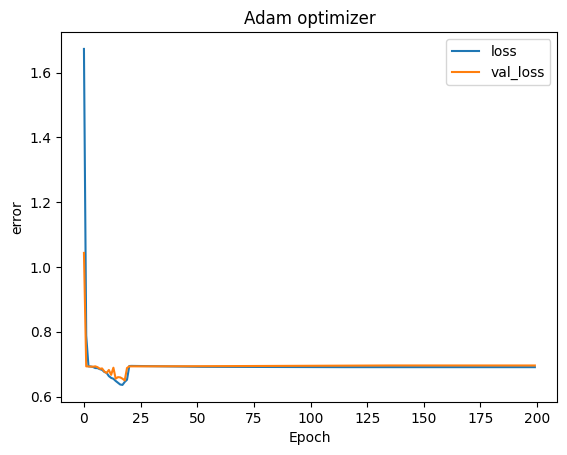

In [32]:
model_2_new_adam = MLPClassify_9_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

In [33]:
from keras import regularizers
class MLPClassify_10_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]),)
        self.net.add(Dense(750, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dense(500, activation='relu'))
        # self.net.add(Dense(172, activation='relu'))
        self.net.add(Dense(10, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 172)               29412     
                                                                 


 dense_46 (Dense)            (None, 750)               129750    
                                                                 
 dense_47 (Dense)            (None, 10)                7510      
                                                                 
 dense_48 (Dense)            (None, 1)                 11        
                                                                 
Total params: 166,683
Trainable params: 166,683
Non-trainable params: 0
_________________________________________________________________
73/73 [==============================] - 0s 4ms/step - loss: 0.6992 - Accuracy: 0.4959


[0.6991887092590332, 0.495931476354599]

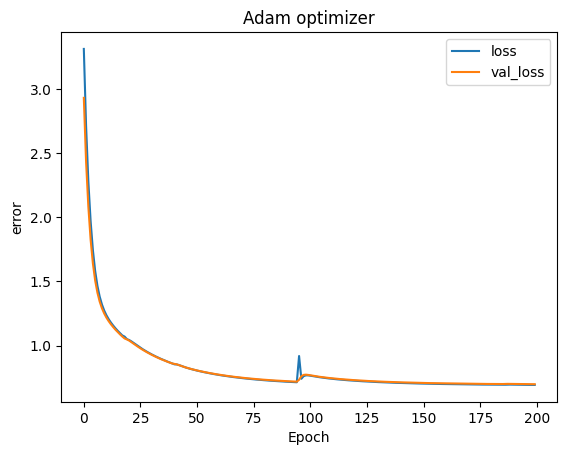

In [34]:
model_2_new_adam = MLPClassify_10_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

In [37]:
from keras import regularizers
class MLPClassify_11_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='relu', input_shape = x_train.shape[1:]),)
        self.net.add(Dense(2000, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dense(500, activation='relu'))
        # self.net.add(Dense(172, activation='relu'))
        self.net.add(Dense(10, activation='relu'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 172)               29412     
                                                                 
 dense_54 (Dense)            (None, 2000)              346000    
                                                                 
 dense_55 (Dense)            (None, 10)                20010     
                                                                 
 dense_56 (Dense)            (None, 1)                 11        
                                                                 
Total params: 395,433
Trainable params: 395,433
Non-trainable params: 0
_________________________________________________________________
73/73 [==============================] - 0s 4ms/step - loss: 0.7004 - Accuracy: 0.4959


[0.700446367263794, 0.495931476354599]

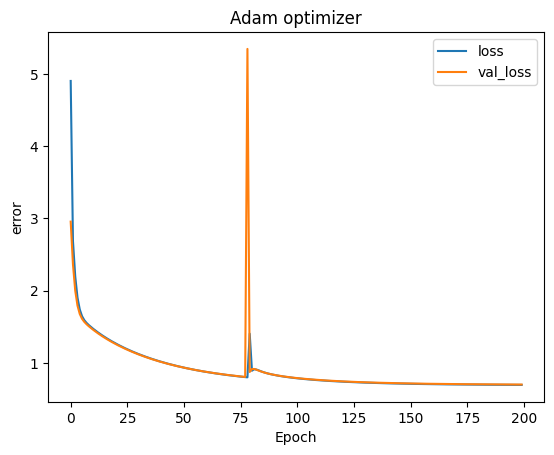

In [38]:
model_2_new_adam = MLPClassify_11_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=200,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

### Dropouts
Let's give dropouts another shot. The idea is that we start with 2000 and pair down. We're gonna spin up the epochs a little as well to let it pair down more.

In [41]:
from keras import regularizers
from keras.layers import Dropout
class MLPClassify_12_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='sigmoid', input_shape = x_train.shape[1:]))
        self.net.add(Dense(2000,activation='sigmoid', input_shape = x_train.shape[1:],kernel_regularizer=regularizers.l2(0.01)))
        self.net.add(Dropout(0.1))
        # self.net.add(Dense(500, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dropout(0.1))
        # self.net.add(Dense(500, activation='relu'))
        # self.net.add(Dense(172, activation='relu'))
        self.net.add(Dense(10, activation='sigmoid'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 172)               29412     
                                                                 
 dense_58 (Dense)            (None, 2000)              346000    
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_59 (Dense)            (None, 10)                20010     
                                                                 
 dense_60 (Dense)            (None, 1)                 11        
                                                                 
Total params: 395,433
Trainable params: 395,433
Non-trainable params: 0
_________________________________________________________________


73/73 [==============================] - 0s 3ms/step - loss: 0.6965 - Accuracy: 0.4959


[0.6964799165725708, 0.495931476354599]

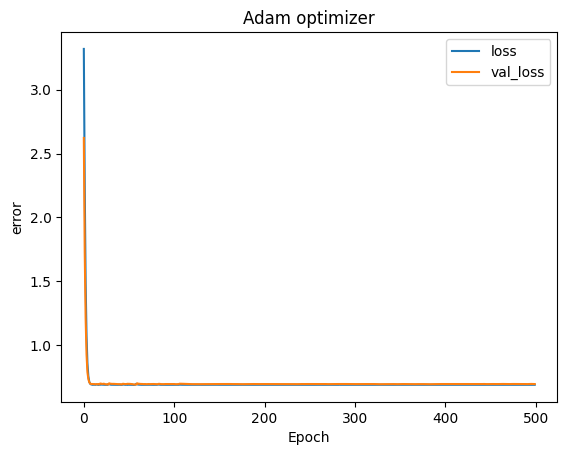

In [42]:
model_2_new_adam = MLPClassify_12_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=500,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

In [43]:
from keras import regularizers
from keras.layers import Dropout
class MLPClassify_13_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='sigmoid', input_shape = x_train.shape[1:]))
        self.net.add(Dense(2000,activation='sigmoid', input_shape = x_train.shape[1:],kernel_regularizer=regularizers.l2(0.01)))
        self.net.add(Dropout(0.2))
        # self.net.add(Dense(500, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dropout(0.1))
        # self.net.add(Dense(500, activation='relu'))
        # self.net.add(Dense(172, activation='relu'))
        self.net.add(Dense(10, activation='sigmoid'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 172)               29412     
                                                                 
 dense_66 (Dense)            (None, 2000)              346000    
                                                                 
 dropout_2 (Dropout)         (None, 2000)              0         
                                                                 
 dense_67 (Dense)            (None, 10)                20010     
                                                                 
 dense_68 (Dense)            (None, 1)                 11        
                                                                 
Total params: 395,433
Trainable params: 395,433
Non-trainable params: 0
_________________________________________________________________
73/73 [==============================] - 0s 3ms

[0.7236154675483704, 0.6753747463226318]

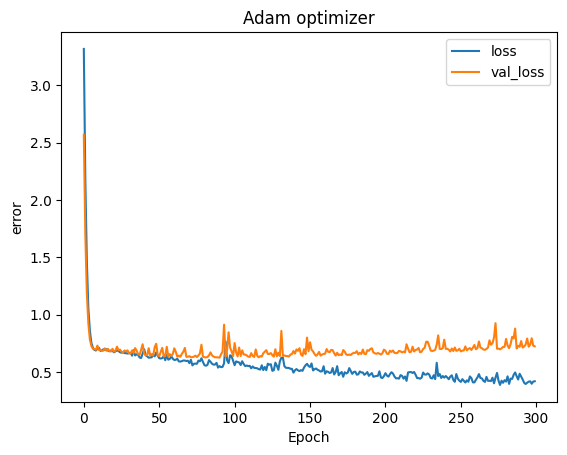

In [45]:
model_2_new_adam = MLPClassify_13_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=300,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

In [46]:
from keras import regularizers
from keras.layers import Dropout
class MLPClassify_14_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='sigmoid', input_shape = x_train.shape[1:]))
        self.net.add(Dense(2000,activation='sigmoid', input_shape = x_train.shape[1:],kernel_regularizer=regularizers.l2(0.01)))
        self.net.add(Dropout(0.3))
        # self.net.add(Dense(500, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dropout(0.1))
        # self.net.add(Dense(500, activation='relu'))
        # self.net.add(Dense(172, activation='relu'))
        self.net.add(Dense(10, activation='sigmoid'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 172)               29412     
                                                                 
 dense_70 (Dense)            (None, 2000)              346000    
                                                                 
 dropout_3 (Dropout)         (None, 2000)              0         
                                                                 
 dense_71 (Dense)            (None, 10)                20010     
                                                                 
 dense_72 (Dense)            (None, 1)                 11        
                                                                 
Total params: 395,433
Trainable params: 395,433
Non-trainable params: 0
_________________________________________________________________
73/73 [==============================] - 0s 4ms

[0.6874908804893494, 0.6835117936134338]

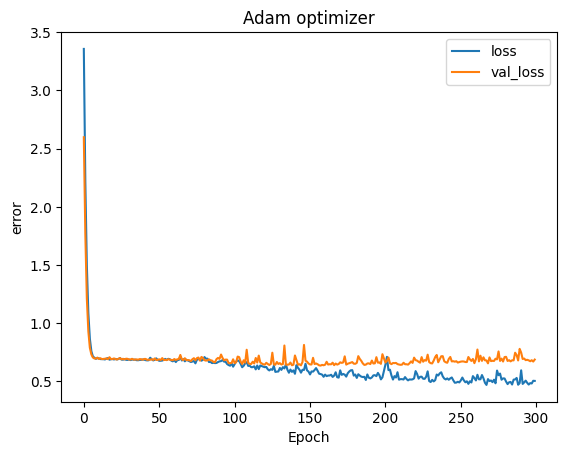

In [47]:
model_2_new_adam = MLPClassify_14_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=300,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

In [48]:
from keras import regularizers
from keras.layers import Dropout
class MLPClassify_15_new(keras.Model):

    def __init__(self):
        super().__init__()

        # TODO: build a neural network
        self.net = keras.Sequential()
        self.net.add(Dense(172, activation='sigmoid', input_shape = x_train.shape[1:]))
        self.net.add(Dense(2000,activation='sigmoid', input_shape = x_train.shape[1:],kernel_regularizer=regularizers.l2(0.01)))
        self.net.add(Dropout(0.4))
        # self.net.add(Dense(500, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))
        # self.net.add(Dropout(0.1))
        # self.net.add(Dense(500, activation='relu'))
        # self.net.add(Dense(172, activation='relu'))
        self.net.add(Dense(10, activation='sigmoid'))
        self.net.add(Dense(1, activation='sigmoid'))

        self.net.summary()

    def call(self, input):
        # TODO: forward pass
        x = self.net(input)
        return x

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 172)               29412     
                                                                 
 dense_74 (Dense)            (None, 2000)              346000    
                                                                 
 dropout_4 (Dropout)         (None, 2000)              0         
                                                                 
 dense_75 (Dense)            (None, 10)                20010     
                                                                 
 dense_76 (Dense)            (None, 1)                 11        
                                                                 
Total params: 395,433
Trainable params: 395,433
Non-trainable params: 0
_________________________________________________________________
73/73 [==============================] - 0s 4ms

[0.6957808136940002, 0.495931476354599]

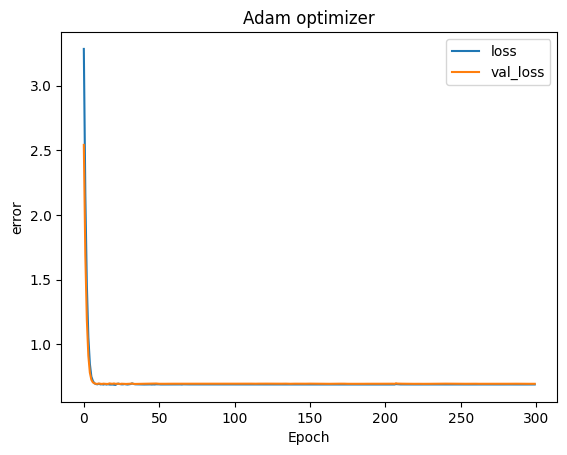

In [49]:
model_2_new_adam = MLPClassify_15_new()
model_2_new_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics='Accuracy')

history = model_2_new_adam.fit(
    np_x_train_all,
    np_y_train_all,
    epochs=300,
    validation_data=(np_x_test_all,np_y_test_all),
    verbose=False)

plot_learning(history, title='Adam optimizer')
model_2_new_adam.evaluate(np_x_test_all, np_y_test_all)

### Conclusion
It seems that we did best with MLPClassify_13_new with the .3 dropout and the 2000 first deep layer with an accuracy of .6835. This is pretty good for sports betting. I theorize that in the case of good model performance, but underfitting, we are missing data to completely answer our question. For next year I plan on doing more detailed featured engineering. I think that rolling averages and window functions would be a huge differentiator